In [1]:
import glob
import os
import sys

from tqdm import tqdm
import numpy as np
from sklearn.metrics import log_loss, brier_score_loss

sys.path.append('../..')
from helpers.settings import models_folder, arrays_folder, sheets_folder

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import OrderedDict
import pandas as pd
%matplotlib inline

In [3]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'sans-serif': ['CMU Serif']})
rc('text', usetex=True)

In [4]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [5]:
from matplotlib.patches import Rectangle

## parameters

In [6]:
n_selected = 5
architecture = 'inceptionv3'
sigmas = np.logspace(-4, -2, 10)[:-1]
sigmas = np.linspace(1e-5, 5e-3, 20)
print(sigmas)

[1.00000000e-05 2.72631579e-04 5.35263158e-04 7.97894737e-04
 1.06052632e-03 1.32315789e-03 1.58578947e-03 1.84842105e-03
 2.11105263e-03 2.37368421e-03 2.63631579e-03 2.89894737e-03
 3.16157895e-03 3.42421053e-03 3.68684211e-03 3.94947368e-03
 4.21210526e-03 4.47473684e-03 4.73736842e-03 5.00000000e-03]


## reading arrays

In [7]:
n_samples = 50000
n_batch = 50
samples_per_batch = n_samples// n_batch
print(samples_per_batch)

1000


In [8]:
n_classes = 1000
n_ensembles = 5
y_pred_ensembles = dict()
for sigma in sigmas:
    image_net_model_folder = os.path.join(models_folder, architecture + '_sigma_chart', str(sigma))
    os.path.isdir(image_net_model_folder)
    y_pred_ensembles[sigma] = np.zeros((n_ensembles, n_selected*samples_per_batch, n_classes))
y_pred_base = np.zeros((n_selected*samples_per_batch, n_classes))

In [9]:
true_path = os.path.join(image_net_model_folder, 'y_true_' + str(0) + '.npy')
y_true = np.load(true_path)[:n_selected*samples_per_batch, ...]
print(y_true.shape)

(5000, 1000)


In [10]:
for sigma in tqdm(sigmas):
    image_net_model_folder = os.path.join(models_folder, architecture + '_sigma_chart', str(sigma))
    for i in range(n_selected):
        base_path = os.path.join(image_net_model_folder, 'y_pred_base_' + str(i) + '.npy')
        ensemble_path = os.path.join(image_net_model_folder, 'y_pred_ensemble_' + str(i) + '.npy')
        y_pred_base[i*samples_per_batch: (i+1)*samples_per_batch] = np.load(base_path)
        y_pred_ensembles[sigma][:, i*samples_per_batch: (i+1)*samples_per_batch] = np.load(ensemble_path)

100%|██████████| 20/20 [00:01<00:00, 12.53it/s]


In [11]:
y_pred_ensemble_means = dict()
for sigma in sigmas:
    y_pred_ensemble_means[sigma] = np.mean(y_pred_ensembles[sigma], axis=0)

In [12]:
nll_baseline = log_loss(y_true,y_pred_base)

In [13]:
nlls = np.zeros(len(sigmas))
nll_baseline = log_loss(y_true,y_pred_base)
print('baseline: NLL :{0:.4f}'.format(nll_baseline))
for index, sigma in enumerate(sigmas):
    nll_perturbed = log_loss(y_true,y_pred_ensemble_means[sigma])
    nlls[index] = nll_perturbed
    print('sigma {0:.4f}: NLL: {1:.4f}'.format(sigma, nll_perturbed))

baseline: NLL :0.9571
sigma 0.0000: NLL: 0.9571
sigma 0.0003: NLL: 0.9563
sigma 0.0005: NLL: 0.9549
sigma 0.0008: NLL: 0.9531
sigma 0.0011: NLL: 0.9512
sigma 0.0013: NLL: 0.9494
sigma 0.0016: NLL: 0.9482
sigma 0.0018: NLL: 0.9476
sigma 0.0021: NLL: 0.9478
sigma 0.0024: NLL: 0.9493
sigma 0.0026: NLL: 0.9519
sigma 0.0029: NLL: 0.9561
sigma 0.0032: NLL: 0.9621
sigma 0.0034: NLL: 0.9700
sigma 0.0037: NLL: 0.9804
sigma 0.0039: NLL: 0.9934
sigma 0.0042: NLL: 1.0094
sigma 0.0045: NLL: 1.0287
sigma 0.0047: NLL: 1.0516
sigma 0.0050: NLL: 1.0785


In [14]:
nlls = np.zeros(len(sigmas))
nll_baseline = log_loss(y_true,y_pred_base)
print('baseline: NLL :{0:.4f}'.format(nll_baseline))
for index, sigma in enumerate(sigmas):
    nll_perturbed = log_loss(y_true,y_pred_ensemble_means[sigma])
    nlls[index] = nll_perturbed
    print('sigma {0:.4f}: NLL: {1:.4f}'.format(sigma, nll_perturbed))

baseline: NLL :0.9571
sigma 0.0000: NLL: 0.9571
sigma 0.0003: NLL: 0.9563
sigma 0.0005: NLL: 0.9549
sigma 0.0008: NLL: 0.9531
sigma 0.0011: NLL: 0.9512
sigma 0.0013: NLL: 0.9494
sigma 0.0016: NLL: 0.9482
sigma 0.0018: NLL: 0.9476
sigma 0.0021: NLL: 0.9478
sigma 0.0024: NLL: 0.9493
sigma 0.0026: NLL: 0.9519
sigma 0.0029: NLL: 0.9561
sigma 0.0032: NLL: 0.9621
sigma 0.0034: NLL: 0.9700
sigma 0.0037: NLL: 0.9804
sigma 0.0039: NLL: 0.9934
sigma 0.0042: NLL: 1.0094
sigma 0.0045: NLL: 1.0287
sigma 0.0047: NLL: 1.0516
sigma 0.0050: NLL: 1.0785


In [19]:
nll_individual_models = dict()
nll_individual_models_mean = np.zeros(len(sigmas))
for si, sigma in enumerate(tqdm(sigmas)):
    nll_individuals = np.zeros(n_ensembles)
    for ensemble_index in range(n_ensembles):
        nll_individuals[ensemble_index] = log_loss(y_true, y_pred_ensembles[sigma][ensemble_index])
    nll_individual_models[sigma] = nll_individuals
    nll_individual_models_mean[si] = np.mean(nll_individuals)

100%|██████████| 20/20 [00:41<00:00,  2.05s/it]


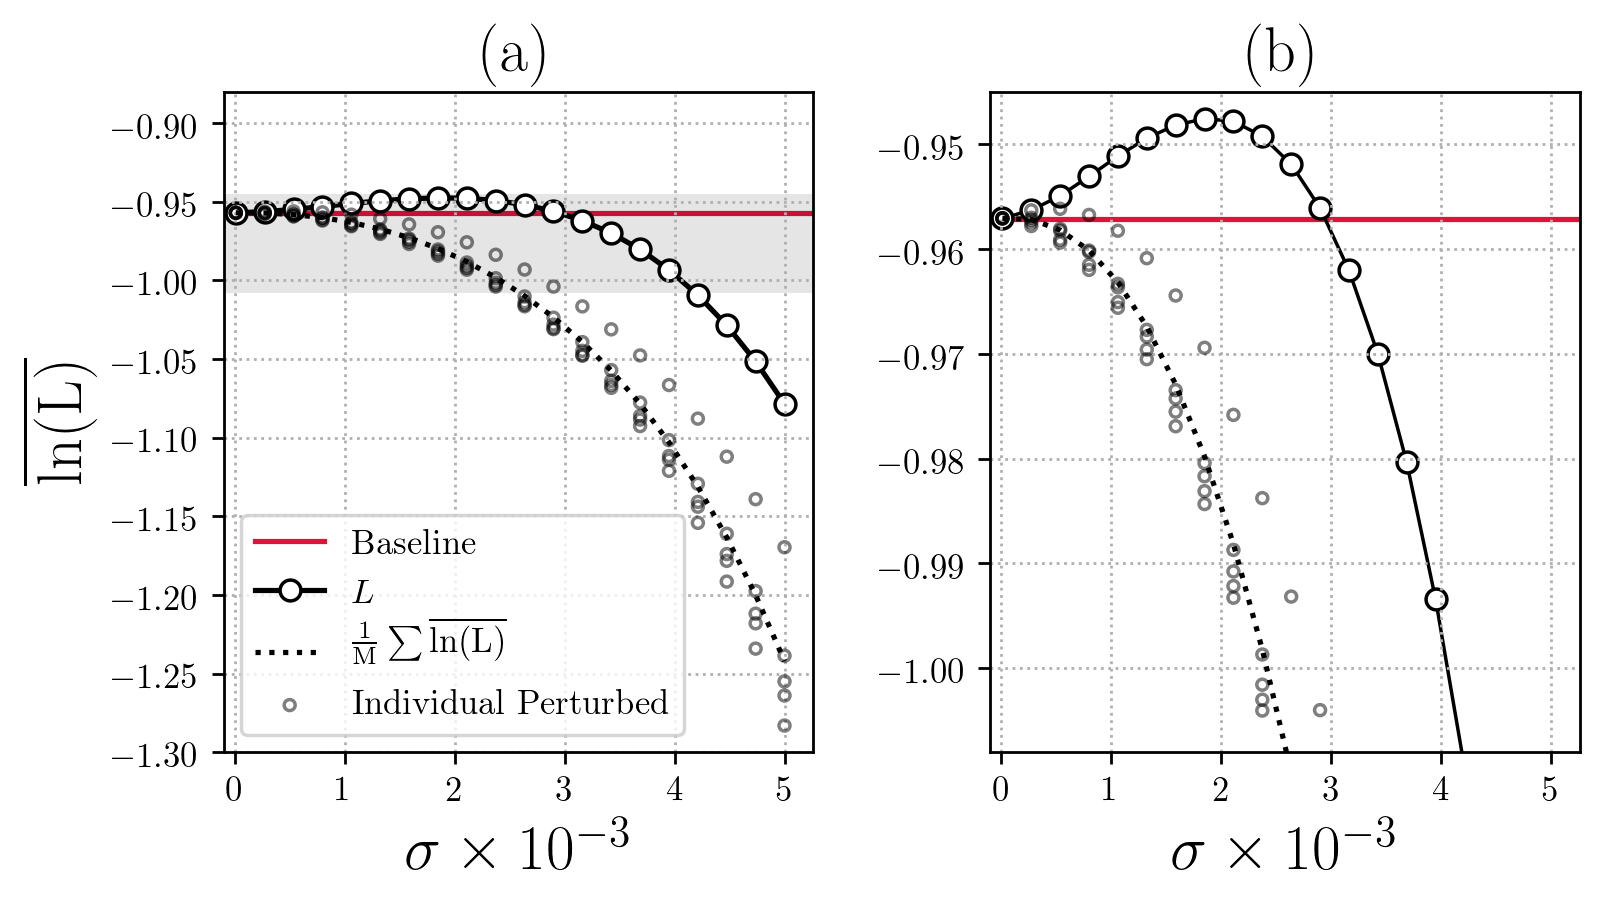

In [20]:
font_size = 18
fig = plt.figure(figsize=(7,3.5), dpi=250)
plt.subplots_adjust(wspace=0.3, hspace=0)
ax1 = fig.add_subplot(1,2,1)
ax1.axhline(y=-nll_baseline, color='crimson', linestyle='-', label='Baseline', zorder=0)
ax1.plot(sigmas, -nlls, markeredgecolor='k', markerfacecolor='w',
         color='k',linestyle='-', marker='o', zorder=1, label=r'$L$')
plt.ylim([-1.3, -0.88])
ax1.set_ylabel(r'$\rm{\overline{ln(L)}}$', fontsize=font_size)
ax1.set_xlabel(r'$\rm{\sigma\times10^{-3}}$', fontsize=font_size)
ax1.grid(which='major', alpha=1, linestyle=':')
ax1.set_xlim([-0.0001,0.005 + (sigmas[1]-sigmas[0])])
ticks = np.linspace(0,0.005, 6)
ax1.set_xticks(ticks)
ax1.set_xticklabels(['{0}'.format(int(tick*1e3)) for tick in ticks])

for sigma in sigmas:
    data = -nll_individual_models[sigma]
    if sigma == sigmas[0]:
        ax1.scatter(np.ones_like(data)*sigma, data, 
                    marker='o', edgecolor='k', facecolor='', s=10,zorder=2, label='Individual Perturbed', alpha=0.5)
    else:
        ax1.scatter(np.ones_like(data)*sigma, data, marker='o', edgecolor='k', facecolor='', s=10,zorder=2,  alpha=0.5)
            
ax1.plot(sigmas, -nll_individual_models_mean, color='k', linestyle=':', 
         label=r'$\rm{\frac{1}{M}\sum{\overline{ln(L)}}}$', zorder=3)
ax1.set_title('(a)', fontsize=18)
ax1.legend(loc=3)
#
rect = Rectangle((-0.0001,-1.008),5e-3 + 2*(sigmas[1]-sigmas[0]), 1.008-0.945, linewidth=0,facecolor='k', alpha=0.1)
ax1.add_patch(rect)

#
ax2 = fig.add_subplot(1,2,2)
ax2.set_ylim([-1.008, -0.945])
ax2.set_xlim([-0.0001,0.005 + (sigmas[1]-sigmas[0])])
ticks = np.linspace(0,0.005, 6)
ax2.set_xticks(ticks)
ax2.set_xticklabels(['{0}'.format(int(tick*1e3)) for tick in ticks])
ax2.axhline(y=-nll_baseline, color='crimson', linestyle='-', label='baseline',zorder=0)
ax2.plot(sigmas, -nlls, markeredgecolor='k', markerfacecolor='w',color='k',linestyle='-', marker='o', zorder=1, lw=1)
ax2.set_xlabel(r'$\rm{\sigma\times10^{-3}}$', fontsize=font_size)
ax2.grid(which='major', alpha=1, linestyle=':')

for sigma in sigmas:
    data = -nll_individual_models[sigma]
    ax2.scatter(np.ones_like(data)*sigma, data, marker='o', edgecolor='k', facecolor='', s=10, alpha=0.5, zorder=2)
ax2.plot(sigmas, -nll_individual_models_mean, color='k', linestyle=':', zorder=3)
    
ax2.set_title('(b)', fontsize=18)

output_path = os.path.join(models_folder, architecture + '_sigma_chart', 'chart.svg')
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)